# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

### Importing Libraries

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#imports to help me plot my venn diagrams
import matplotlib_venn as venn2
from matplotlib_venn import venn2
from pylab import rcParams

# import the util.py file where I define my functions
from utils import *

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [6]:
# load in the data
azdias = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\azdias.csv")
customers = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\customers.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
'''
There are 2 warnings when we read in the datasets:
DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
interactivity=interactivity, compiler=compiler, result=result)

This warning happens when pandas attempts to guess datatypes on particular columns 
To fix it I shall specify dtypes
'''
# load in the data specifying dtypes for column 19 and 20

azdias = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\azdias.csv", dtype={19:'str',20:'str'})
customers = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\customers.csv", dtype={19:'str',20:'str'})

In [10]:
# checking how the azdias dataframe looks like
print('Printing basic statistical information')
print(azdias.describe())
print('________________________________________________________')
print('Printing dataframe shape')
print(azdias.shape)
print('________________________________________________________')

azdias.head()

Printing basic statistical information
          Unnamed: 0           LNR       AGER_TYP     AKT_DAT_KL  \
count  891221.000000  8.912210e+05  891221.000000  817722.000000   
mean   445610.000000  6.372630e+05      -0.358435       4.421928   
std    257273.486465  2.572735e+05       1.198724       3.638805   
min         0.000000  1.916530e+05      -1.000000       1.000000   
25%    222805.000000  4.144580e+05      -1.000000       1.000000   
50%    445610.000000  6.372630e+05      -1.000000       3.000000   
75%    668415.000000  8.600680e+05      -1.000000       9.000000   
max    891220.000000  1.082873e+06       3.000000       9.000000   

            ALTER_HH   ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  817722.000000  81058.000000  29499.000000  6170.000000  1205.000000   
mean       10.864126     11.745392     13.402658    14.476013    15.089627   
std         7.639683      4.097660      3.243300     2.712427     2.452932   
min         0.000000      2.000000  

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [11]:
# checking how the customer dataframe looks like
print('Printing basic statistical information')
print(customers.describe())
print('________________________________________________________')
print('Printing dataframe shape')
print(customers.shape)
print('________________________________________________________')

customers.head()

Printing basic statistical information
          Unnamed: 0            LNR       AGER_TYP     AKT_DAT_KL  \
count  191652.000000  191652.000000  191652.000000  145056.000000   
mean    95825.500000   95826.500000       0.344359       1.747525   
std     55325.311233   55325.311233       1.391672       1.966334   
min         0.000000       1.000000      -1.000000       1.000000   
25%     47912.750000   47913.750000      -1.000000       1.000000   
50%     95825.500000   95826.500000       0.000000       1.000000   
75%    143738.250000  143739.250000       2.000000       1.000000   
max    191651.000000  191652.000000       3.000000       9.000000   

            ALTER_HH   ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  145056.000000  11766.000000  5100.000000  1275.000000   236.000000   
mean       11.352009     12.337243    13.672353    14.647059    15.377119   
std         6.275026      4.006050     3.243335     2.753787     2.307653   
min         0.000000      2.000

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [20]:
# Check the provided summary csv file
feat_sum = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\DIAS Attributes - Values 2017.csv")
#define index for print out set
feat_sum.set_index('Attribute', inplace=True)
print('________________________________________________________')
print('Printing dataframe shape')
print(feat_sum.shape)
feat_sum.head()

________________________________________________________
Printing dataframe shape
(2258, 3)


,Description,Value,Meaning
Attribute,,,
AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,0,no classification possible
NaN,NaN,1,passive elderly
NaN,NaN,2,cultural elderly
NaN,NaN,3,experience-driven elderly


### On the dataframe shapes:

#### For now it is noted that the 3 initial working dataframes had shape discrepancy between them (rows, columns):
#### azdias: (891221, 367)
#### customers: (191652, 370)
#### feat_sum: (2258, 3)

### Next I will check how many of the features in the feat_info column are common with the azdias dataframe.

In [24]:
#checking attributes present in azdias dataframe but missing in the feat_sum dataframe
att_missing_in_feat_sum = np.setdiff1d(np.array(azdias.columns), np.array(feat_sum.index), assume_unique=True)

#checking attributes common in azdias dataframe and feat_sum dataframe
att_common = set(azdias.columns.tolist()).intersection(set(feat_sum.index.tolist()))

#checking attributes in feat_sum but not in azdias
att_missing_in_azdias = set(feat_sum.index.tolist()) - att_common

print('There are ' + str(len(att_missing_in_info)) + ' attributes in azdias that are not present in feat_sum')
print('There are ' + str(len(att_common)) + ' attributes common between azdias and feat_sum')
print('There are ' + str(len(att_missing_in_azdias)) + ' attributes in feat_sum that are not present in azdias')

There are 95 attributes in azdias that are not present in feat_sum
There are 272 attributes common between azdias and feat_sum
There are 43 attributes in feat_sum that are not present in azdias


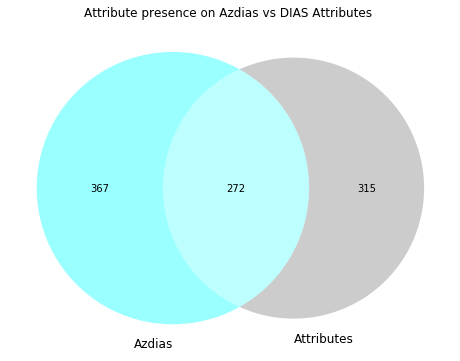

In [42]:
#plotting the findings on overlapping data
import matplotlib_venn as venn2
from matplotlib_venn import venn2
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8


azdias_unique = pd.unique(azdias.columns)
feat_unique = pd.unique(feat_sum.index)
ax = plt.axes()
ax.set_facecolor('lightgrey')
v = venn2(subsets = (len(azdias_unique), len(feat_unique), len(att_common)), 
      set_labels=('Azdias', 'Attributes'),
         set_colors = ['cyan', 'grey']);

plt.title("Attribute presence on Azdias vs DIAS Attributes ")
plt.show()

## Preprocessing
### Now that I have a birds-eye view of the data I will proceed with cleaning and handling missing calues, re-encode features (since the first portion of this project will involve unsupervised learning), perform some feature enginnering and scaling.

In [90]:
percent_missing_azdias_df = percentage_of_missing(azdias)
percent_missing_azdias_df.head()

,column_name,percent_missing
Unnamed: 0,Unnamed: 0,0.000
LNR,LNR,0.000
AGER_TYP,AGER_TYP,0.000
AKT_DAT_KL,AKT_DAT_KL,8.247
ALTER_HH,ALTER_HH,8.247


In [91]:
percent_missing_customers_df = percentage_of_missing(customers)
percent_missing_customers_df.head()

,column_name,percent_missing
Unnamed: 0,Unnamed: 0,0.000000
LNR,LNR,0.000000
AGER_TYP,AGER_TYP,0.000000
AKT_DAT_KL,AKT_DAT_KL,24.312817
ALTER_HH,ALTER_HH,24.312817


In [87]:
print('Empty cells in Azdias dataframe: ', azdias.isnull().sum().sum())
print('Empty cells in Customers dataframe: ', customers.isnull().sum().sum())
print('________________________________________________________')
print("Number of Azdias columns not missing values: ", ((percent_missing_azdias_df['percent_missing'] == 0.0).sum()))
print("Number of Customers columns not missing values: ", ((percent_missing_customers_df['percent_missing'] == 0.0).sum()))

Empty cells in Azdias dataframe:  33492923
Empty cells in Customers dataframe:  13864522
________________________________________________________
Number of Azdias columns not missing values:  94
Number of Customers columns not missing values:  97


In [98]:
azdias_missing_over_30 = split_on_percentage(percent_missing_azdias_df, 30, '>')
azdias_missing_less_30 = split_on_percentage(percent_missing_azdias_df, 30, '<=')
print(azdias_missing_over_30.head())
print(azdias_missing_less_30.head())


             column_name  percent_missing
ALTER_KIND1  ALTER_KIND1        90.904837
ALTER_KIND2  ALTER_KIND2        96.690047
ALTER_KIND3  ALTER_KIND3        99.307691
ALTER_KIND4  ALTER_KIND4        99.864792
EXTSEL992      EXTSEL992        73.399639
           column_name  percent_missing
Unnamed: 0  Unnamed: 0            0.000
LNR                LNR            0.000
AGER_TYP      AGER_TYP            0.000
AKT_DAT_KL  AKT_DAT_KL            8.247
ALTER_HH      ALTER_HH            8.247
             column_name  percent_missing
ALTER_KIND1  ALTER_KIND1        93.860748
ALTER_KIND2  ALTER_KIND2        97.338927
ALTER_KIND3  ALTER_KIND3        99.334732
ALTER_KIND4  ALTER_KIND4        99.876860
EXTSEL992      EXTSEL992        44.498883
           column_name  percent_missing
Unnamed: 0  Unnamed: 0         0.000000
LNR                LNR         0.000000
AGER_TYP      AGER_TYP         0.000000
AKT_DAT_KL  AKT_DAT_KL        24.312817
ALTER_HH      ALTER_HH        24.312817


In [94]:
customers_missing_over_30 = split_on_percentage(percent_missing_customers_df, 30, '>')
customers_missing_less_30 = split_on_percentage(percent_missing_customers_df, 30, '<=')
print(customers_missing_over_30.head())
print(customers_missing_less_30.head())

             column_name  percent_missing
ALTER_KIND1  ALTER_KIND1        93.860748
ALTER_KIND2  ALTER_KIND2        97.338927
ALTER_KIND3  ALTER_KIND3        99.334732
ALTER_KIND4  ALTER_KIND4        99.876860
EXTSEL992      EXTSEL992        44.498883
           column_name  percent_missing
Unnamed: 0  Unnamed: 0         0.000000
LNR                LNR         0.000000
AGER_TYP      AGER_TYP         0.000000
AKT_DAT_KL  AKT_DAT_KL        24.312817
ALTER_HH      ALTER_HH        24.312817


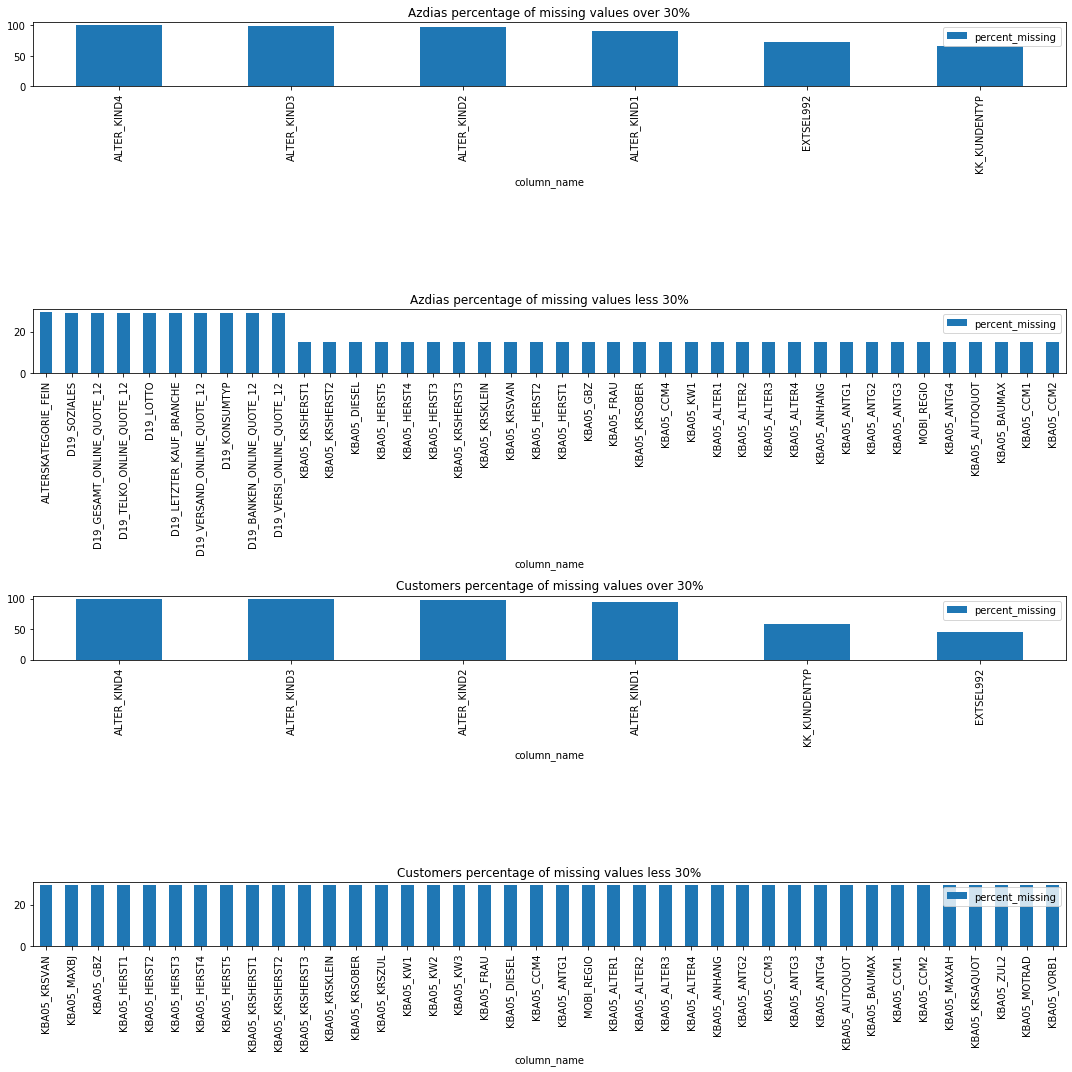

In [100]:
figure, axes = plt.subplots(4, 1, figsize = (15,15), squeeze = False)

azdias_missing_over_30.sort_values(by = 'percent_missing', ascending = False).plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[0][0], title = 'Azdias percentage of missing values over 30%' )

#due to the sheer amount of data points to be plotted this does not make an appealing vis so I will restrict
#the number of plotted points to 40
azdias_missing_less_30.sort_values(by = 'percent_missing', ascending = False)[:40].plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[1][0], title = 'Azdias percentage of missing values less 30%' )

customers_missing_over_30.sort_values(by = 'percent_missing', ascending = False).plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[2][0], title = 'Customers percentage of missing values over 30%' )

#due to the sheer amount of data points to be plotted this does not make an appealing vis so I will restrict
#the number of plotted points to 40
customers_missing_less_30.sort_values(by = 'percent_missing', ascending = False)[:40].plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[3][0], title = 'Customers percentage of missing values less 30%' )

plt.tight_layout()
plt.show()

### The vast majority of the columns with missing values have a percent of missing under 30% which might means there is some recoverable data.
### Based on this information I will remove columns with more than 30% missing values

In [105]:
#extracting column names with more than 30% values missing so we can drop them from azdias df
azdias_col_delete = columns_to_delete(azdias_missing_over_30)

#extracting column names with more than 30% values missing so we can drop them from customers df
customers_col_delete = columns_to_delete(customers_missing_over_30)

In [111]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [122]:
#dropping unnamed column, from now on the _n will correspond to the cleaning step I am at
azdias_1 = azdias.drop(azdias.columns[0], axis = 1)
customers_1 = customers.drop(customers.columns[0], axis = 1)

In [123]:
#dropping the columns identified in the previous lists

azdias_2 = azdias_1.drop(azdias_col_delete, axis = 1)
customers_2 = customers_1.drop(customers_col_delete, axis = 1)

In [124]:
azdias_2.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')